In [1]:
import os
import json
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
sns.set_style("ticks")
sns.set_context("paper")

In [3]:
MODES = ["textual", "visual"]

In [4]:
TASK_NAMES = (
    "close_drawer",
    "lift_blue_block_drawer",
    "lift_blue_block_slider",
    "lift_blue_block_table",
    "lift_pink_block_drawer",
    "lift_pink_block_slider",
    "lift_pink_block_table",
    "lift_red_block_drawer",
    "lift_red_block_slider",
    "lift_red_block_table",
    "move_slider_left",
    "move_slider_right",
    "open_drawer",
    "place_in_drawer",
    "place_in_slider",
    "push_blue_block_left",
    "push_blue_block_right",
    "push_into_drawer",
    "push_pink_block_left",
    "push_pink_block_right",
    "push_red_block_left",
    "push_red_block_right",
    "rotate_blue_block_left",
    "rotate_blue_block_right",
    "rotate_pink_block_left",
    "rotate_pink_block_right",
    "rotate_red_block_left",
    "rotate_red_block_right",
    "stack_block",
    "turn_off_led",
    "turn_off_lightbulb",
    "turn_on_led",
    "turn_on_lightbulb",
    "unstack_block",
)

## Loading Results

In [5]:
# save_dir = "../outputs/gcbc_eval/GCBC-CALVIN-s1"
# save_dir = "../outputs/gcbc_eval/last/suggestive/"
# save_dir = "../outputs/gcbc_eval/last/"
# save_dir = "../outputs/gcbc_cclipt/third/sug_starts"
# save_dir = "../outputs/gcbc_cclipt/third/non_sug_starts"
# save_dir = "../outputs/gcbc_cclipt/ninth/sug_starts"
# save_dir = "../outputs/gcbc_cclipt/ninth/non_sug_starts"
# save_dir = "../outputs/gcbc_cclipt/last/sug_starts"
save_dir = "../outputs/gcbc_cclipt/last/non_sug_starts"
# save_dir = "../outputs/gcbc_rolling_eval/last/sug_starts"
# save_dir = "../outputs/gcbc_rolling_eval/last/non_sug_starts"

In [6]:
def legacy_parse_results(save_dir):
    result_keys = ["results", "evaluated_idxs"]
    results_dict = {
        "textual": {k: None for k in result_keys},
        "visual": {k: None for k in result_keys},
    }
    results_dict["textual"]["save_dir"] = os.path.join(save_dir, "textual")
    results_dict["visual"]["save_dir"] = os.path.join(save_dir, "visual")

    for mode in MODES:
        for key in result_keys:
            file_path = os.path.join(results_dict[mode]["save_dir"], f"{key}.npz")
            results_dict[mode][key] = dict(**np.load(file_path))

    return results_dict


def parse_results(save_dir):
    result_keys = ["results", "evaluated_idxs"]
    results_dict = {
        "textual": {k: None for k in result_keys},
        "visual": {k: None for k in result_keys},
    }

    results_dict["textual"]["save_dir"] = os.path.join(save_dir, "textual")
    results_dict["visual"]["save_dir"] = os.path.join(save_dir, "visual")

    for mode in MODES:
        for key in result_keys:
            results_dict[mode][key] = {}
            for task in TASK_NAMES:
                file_path = os.path.join(
                    results_dict[mode]["save_dir"], task, f"{key}.npz"
                )
                results_dict[mode][key][task] = dict(np.load(file_path))['arr_0']

    return results_dict

In [7]:
# results_dict = legacy_save_format_parse(save_dir)
results_dict = parse_results(save_dir)

In [8]:
tasks = list(results_dict["textual"]["results"].keys())
n_tasks = len(tasks)

## Success Rate

In [9]:
for mode in MODES:
    results = results_dict[mode]["results"]
    success_rates = {k: v.sum() / v.size for k, v in results.items()}
    total_sr = sum([v.sum() for v in results.values()]) / sum(
        [len(v) for v in results.values()]
    )
    results_dict[mode]["success_rates"] = success_rates
    results_dict[mode]["total_sr"] = total_sr

### Main

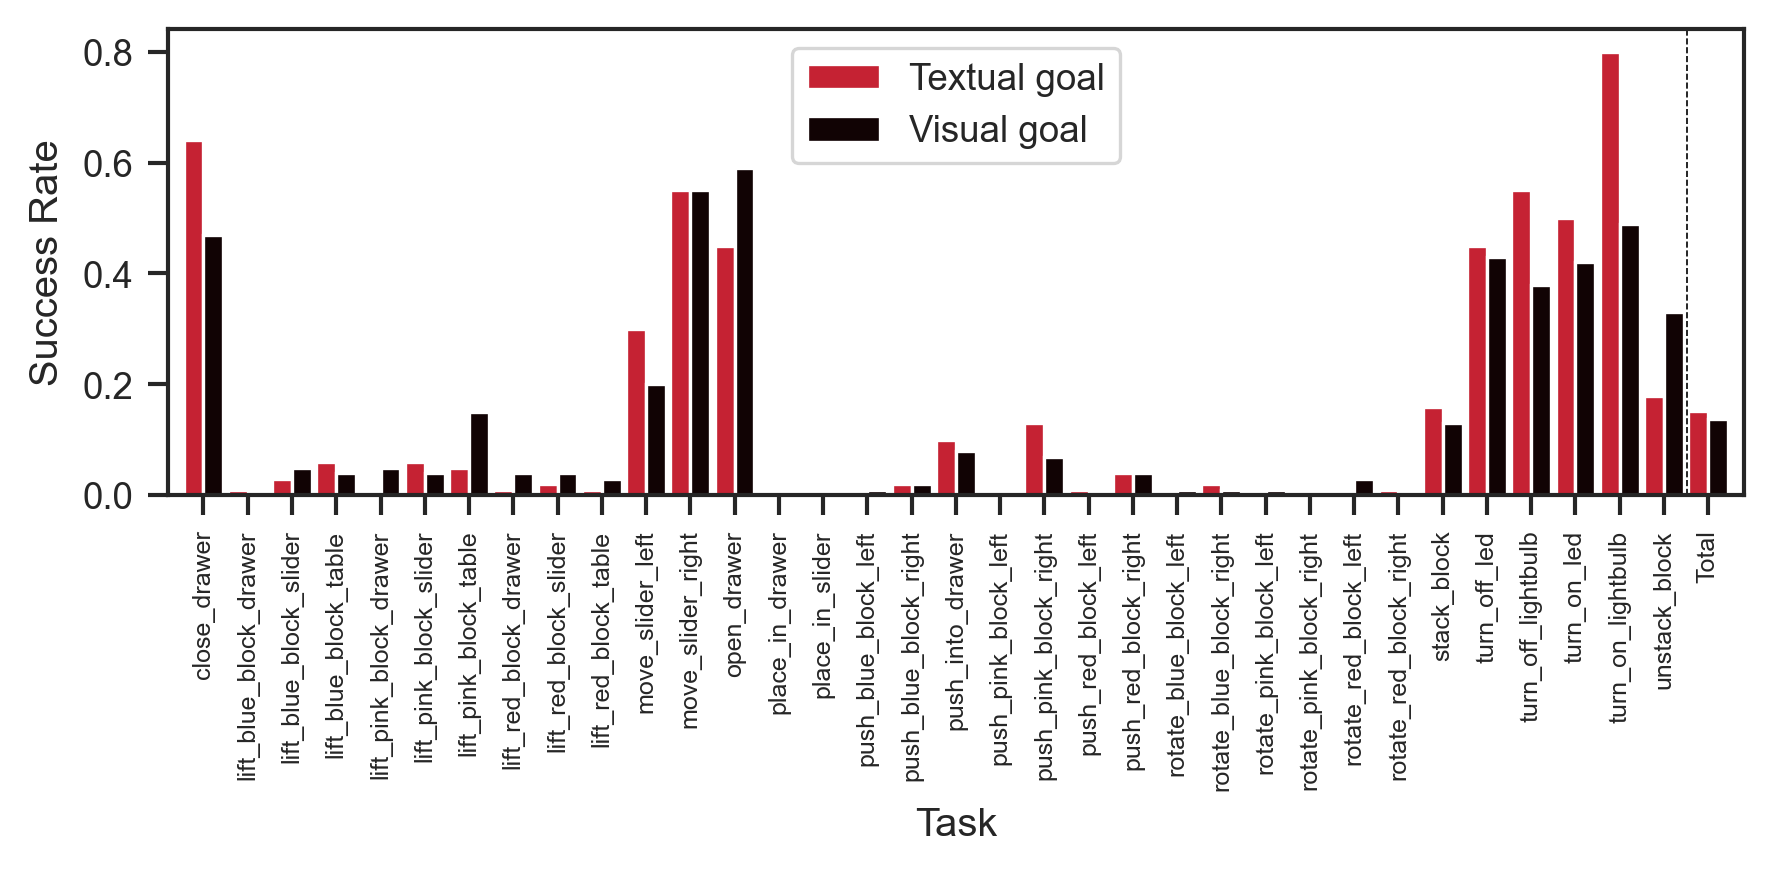

In [10]:
f, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

# Position of bars on x-axis (+1 cuz we also plot the total SR
ind = np.arange(n_tasks + 1)
# Width of a bar
width = 0.45

textual_sr = [results_dict["textual"]["success_rates"][task] for task in tasks]
textual_total_sr = results_dict["textual"]["total_sr"]

visual_sr = [results_dict["visual"]["success_rates"][task] for task in tasks]
visual_total_sr = results_dict["visual"]["total_sr"]

ax.bar(
    x=ind[:-1], height=textual_sr, width=width, color="#C52233", label="Textual goal"
)
ax.bar(
    x=ind[:-1] + width,
    height=visual_sr,
    width=width,
    color="#110304",
    label="Visual goal",
)

ax.bar(x=ind[-1], height=textual_total_sr, width=width, color="#C52233")
ax.bar(x=ind[-1] + width, height=visual_total_sr, width=width, color="#110304")

ax.axvline(x=len(tasks) - 0.25, color="black", linestyle="dashed", linewidth=0.4)

ax.set_xticks(ind + width / 2, tasks + ["Total"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)

ax.set_ylabel("Success Rate")
ax.set_xlabel("Task")

ax.margins(x=0.01)
ax.legend()

f.set_tight_layout(True)
plt.show()

In [11]:
sr_df = pd.DataFrame.from_records(
    [results_dict[mode]["success_rates"] for mode in MODES],
    index=["Textual Success Rate", "Visual Success Rate"],
)
sr_stats = sr_df.T.describe()
sr_df["Total"] = [textual_total_sr, visual_total_sr]

In [12]:
sr_df

,close_drawer,lift_blue_block_drawer,lift_blue_block_slider,lift_blue_block_table,lift_pink_block_drawer,lift_pink_block_slider,lift_pink_block_table,lift_red_block_drawer,lift_red_block_slider,lift_red_block_table,...,rotate_pink_block_right,rotate_red_block_left,rotate_red_block_right,stack_block,turn_off_led,turn_off_lightbulb,turn_on_led,turn_on_lightbulb,unstack_block,Total
Textual Success Rate,0.64,0.01,0.03,0.06,0.00,0.06,0.05,0.01,0.02,0.01,...,0.0,0.00,0.01,0.16,0.45,0.55,0.50,0.80,0.18,0.151765
Visual Success Rate,0.47,0.00,0.05,0.04,0.05,0.04,0.15,0.04,0.04,0.03,...,0.0,0.03,0.00,0.13,0.43,0.38,0.42,0.49,0.33,0.138529


In [13]:
sr_stats

,Textual Success Rate,Visual Success Rate
count,34.000000,34.000000
mean,0.151765,0.138529
std,0.227988,0.189099
min,0.000000,0.000000
25%,0.002500,0.010000
50%,0.025000,0.040000
75%,0.175000,0.187500
max,0.800000,0.590000
